# Re-implementing Tutorial 2 with DL tricks (ResNet, Regularizaion, Normalization)

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dowload the dataset (uncomment if neededabs)
#dataset_url = "http://files.fast.ai/data/cifar10.tgz"
#download_url(dataset_url, '.')

# Extract from archive
#with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#    tar.extractall(path='./data')

# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### In the current implementation we have changed 3 things to boost accuracy:
#### 1. Use test set for validation (Gives more training data - usually done for final training)
#### 2. Channel-wise data normalization (prevents the values from any one channel from disproportionately affecting the losses and gradients while training)
#### 3. Randomized data augmentations (allows better generalizations)

In [3]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [6]:
# To compute stats do the following:

import os
import numpy as np
import tarfile
from PIL import Image
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

data_dir = './data/cifar10'
imgs = [];

for clas in os.listdir(data_dir + "/train"):
    for fname in os.listdir(data_dir +'/train/' + clas):
        img = Image.open(data_dir + '/train/' + clas + '/' + fname)
        img_arr = np.array(img) / 255.
        imgs.append(img_arr)

       
# Conver to a single numpy array
imgs = np.stack(imgs)
# Extarct each channel
reds, greens, blues = imgs[:,:,:,0], imgs[:,:,:,1], imgs[:,:,:,2]
# Channel-wise means
means = np.mean(reds), np.mean(greens), np.mean(blues)
# Channel-wise standard deviations
stds = np.std(reds), np.std(greens), np.std(blues)
means, stds

((0.49139967861519673, 0.48215840839460683, 0.44653091444546533),
 (0.24703223246328232, 0.24348512800005503, 0.2615878417279644))

In [7]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

batch_size = 400

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


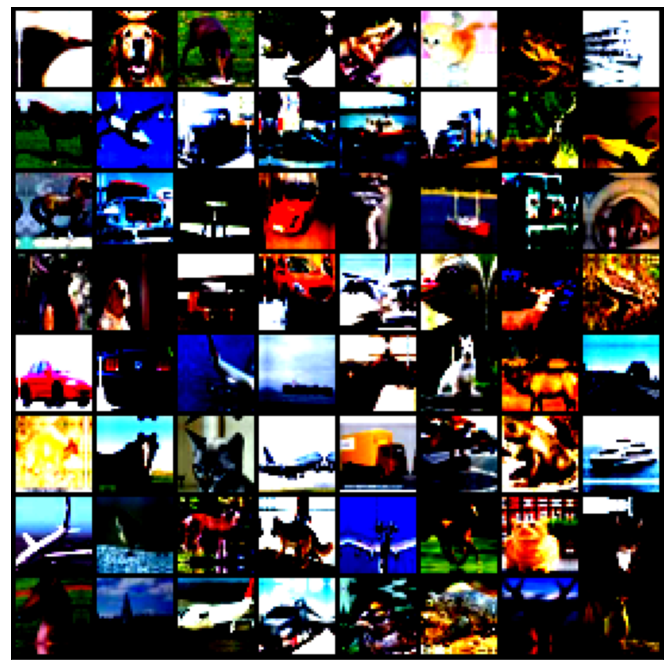

In [10]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl) # color awkward because of normalization

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
# Residual Block is just about adding inputs to the end of the layer and keeping the number of channels same!

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # ResBlock: same number of ip and op channels
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out # ResBlock: add the input to the layer at the end
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
    
model = to_device(ResNet9(3, 10), device) # 3 is the initial channels and 10 is the number of classes

### Improving the training  itself is done using 3 techniques:
#### 1. Use a learning rate scheduler, which will change the learning rate after every batch of training 
#### 2. Use weight decay, which is yet another regularization technique which prevents the weights from becoming too large 
#### 3. Limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3093254566192627, 'val_acc': 0.10730768740177155}]

In [24]:
epochs = 14
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [25]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00167, train_loss: 0.2251, val_loss: 0.4474, val_acc: 0.8625
Epoch [1], last_lr: 0.00483, train_loss: 0.3813, val_loss: 0.6996, val_acc: 0.7814
Epoch [2], last_lr: 0.00819, train_loss: 0.5281, val_loss: 0.8444, val_acc: 0.7237
Epoch [3], last_lr: 0.00995, train_loss: 0.5439, val_loss: 0.8186, val_acc: 0.7282
Epoch [4], last_lr: 0.00984, train_loss: 0.4945, val_loss: 0.7054, val_acc: 0.7682
Epoch [5], last_lr: 0.00919, train_loss: 0.4469, val_loss: 0.4989, val_acc: 0.8323
Epoch [6], last_lr: 0.00812, train_loss: 0.4146, val_loss: 0.7090, val_acc: 0.7764
Epoch [7], last_lr: 0.00673, train_loss: 0.3716, val_loss: 0.5248, val_acc: 0.8291
Epoch [8], last_lr: 0.00516, train_loss: 0.3321, val_loss: 0.4568, val_acc: 0.8462
Epoch [9], last_lr: 0.00358, train_loss: 0.2826, val_loss: 0.5027, val_acc: 0.8398
Epoch [10], last_lr: 0.00214, train_loss: 0.2235, val_loss: 0.3236, val_acc: 0.8874
Epoch [11], last_lr: 0.00099, train_loss: 0.1675, val_loss: 0.2611, val_acc: 0.9137
Ep

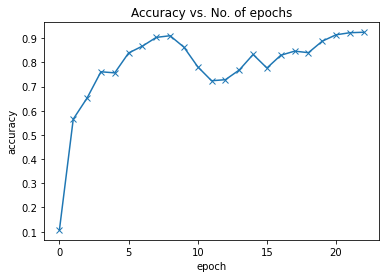

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

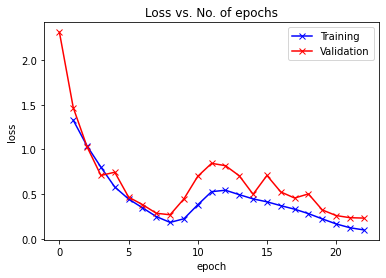

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

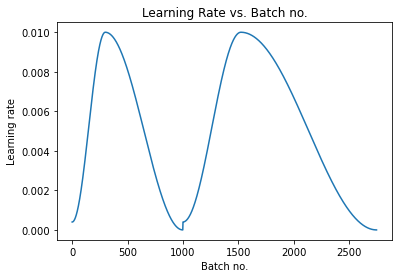

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)